In [1]:
import cv2
import os
import mediapipe as mp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import numpy as np

In [2]:
import cv2, mediapipe as mp, os, pandas as pd

DATASET_PATH = r"data"
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.3)

all_data = []

for label in sorted(os.listdir(DATASET_PATH)):
    folder_path = os.path.join(DATASET_PATH, label)
    if not os.path.isdir(folder_path): continue

    print(f"Processing: {label}")

    for img_name in os.listdir(folder_path)[:300]:  # ⏱ Limit to 300 per letter to save time
        img_path = os.path.join(folder_path, img_name)
        image = cv2.imread(img_path)
        if image is None:
            continue

        image = cv2.resize(image, (256, 256))
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = hands.process(rgb)

        if result.multi_hand_landmarks:
            lm = result.multi_hand_landmarks[0]
            features = [coord for pt in lm.landmark for coord in (pt.x, pt.y, pt.z)]
            features.append(label)
            all_data.append(features)

# Save to CSV
columns = [f"{axis}{i}" for i in range(21) for axis in ['x', 'y', 'z']] + ['label']
df = pd.DataFrame(all_data, columns=columns)
df.to_csv("asl_landmarks_train.csv", index=False)
print("Saved CSV with", len(df), "samples")


Processing: A


KeyboardInterrupt: 

In [3]:
df = pd.read_csv("asl_landmarks_train.csv")
X = df.drop('label', axis=1)
y = LabelEncoder().fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        33
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        30
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        18
          10       1.00      1.00      1.00        17
          11       1.00      1.00      1.00        22
          12       1.00      1.00      1.00         3
          13       1.00      0.88      0.93        16
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        22
          16       1.00      1.00      1.00        16
          17       1.00    

In [4]:
import joblib

joblib.dump(clf, "asl_rf_model.pkl")         # Save model
joblib.dump(LabelEncoder().fit(df['label']), "asl_label_encoder.pkl")  # Save encoder


['asl_label_encoder.pkl']

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import joblib

# Load trained model and label encoder
model = joblib.load("asl_rf_model.pkl")
label_encoder = joblib.load("asl_label_encoder.pkl")

# MediaPipe setup
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(max_num_hands=1, min_detection_confidence=0.3)

# Webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)  # Mirror image
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb)

    if result.multi_hand_landmarks:
        hand = result.multi_hand_landmarks[0]

        # Extract 21 landmarks
        landmarks = []
        for lm in hand.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])

        # Predict letter
        try:
            prediction = model.predict([landmarks])[0]
            predicted_label = label_encoder.inverse_transform([prediction])[0]
            cv2.putText(frame, f"Prediction: {predicted_label}", (10, 70),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
        except:
            pass

        mp_drawing.draw_landmarks(frame, hand, mp_hands.HAND_CONNECTIONS)

    cv2.imshow("ASL Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


c:\Users\Elzoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Elzoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Elzoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Elzoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Elzoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\skl

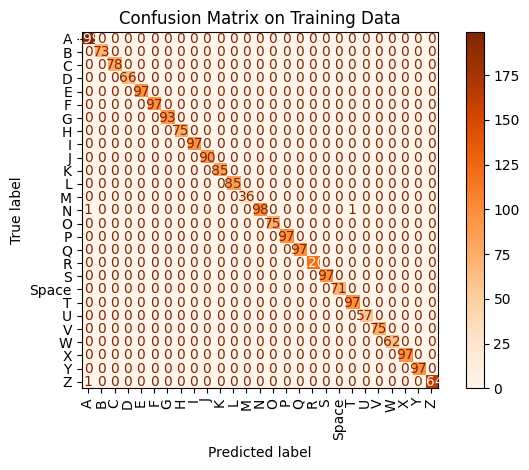

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import pandas as pd

# Load what you already have
model = joblib.load("asl_rf_model.pkl")
le = joblib.load("asl_label_encoder.pkl")
df = pd.read_csv("asl_landmarks_train.csv")

X = df.drop("label", axis=1)
y = le.transform(df["label"])
y_pred = model.predict(X)

# Show confusion matrix
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap="Oranges")
plt.title("Confusion Matrix on Training Data")
plt.tight_layout()
plt.show()
